<a href="https://colab.research.google.com/github/rainforest01-coder/ESAA_files/blob/main/ESAA_WEEK06_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##03 앙상블 학습

###앙상블 학습 개요
여러개의 Classifier를 생성하고 예측을 결합함으로서 보다 정확한 최종 예측을 도출하는 기법

비정형데이터: 딥러닝 /
정형 데이터: 앙상블

앙상블 학습 유형
* 여러개의 분류기가 투표를 통해 최종 예측 결과 결정
  * 보팅: 서로 다른 알고리즘을 가진 분류기 결합
  * 배깅: 분류기가 같은 유형의 알고리즘 기반이지만 데이터 샘플링을 다르게 가져가(부트스트래핑 분할) 학습 수행해 보팅 ex)Random Forest
  > 데이터 세트 간에 중첩 허용
* 부스팅: 여러개의 분류기가 순차적으로 학습을 수행하되 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해서는 올바르게 예측할 수 있도록 다음 분류기에 가중치 부여하며 학습과 예측 진행ex) 그래디언트 부스트, XGBoost, LightGBM

###보팅 유형: 하드 보팅과 소프트 보팅

* 하드보팅: 다수결
* 소프트 보팅: 분류기들의 레이블 값 결정 확률 모두 더해 평균> 일반적으로 사용

### 보팅 분류기

사이킷런: VotingClassifier

In [ ]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer=load_breast_cancer()
data_df=pd.DataFrame(cancer.data,columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [ ]:
lr_clf=LogisticRegression(solver='liblinear')
knn_clf=KNeighborsClassifier(n_neighbors=8)

vo_clf=VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)],voting='soft')
X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,test_size=0.2,random_state=156)

vo_clf.fit(X_train,y_train)
pred=vo_clf.predict(X_test)
print('Voting 분류기 정확도:{0:.4f}'.format(accuracy_score(y_test,pred)))

#개별 모델 학습 예측 평가
classifiers=[lr_clf,knn_clf]
for classifier in classifiers:
  classifier.fit(X_train,y_train)
  pred=classifier.predict(X_test)
  class_name=classifier.__class__.__name__
  print('{0}정확도: {1:.4f}'.format(class_name,accuracy_score(y_test,pred)))

Voting 분류기 정확도:0.9561
LogisticRegression정확도: 0.9474
KNeighborsClassifier정확도: 0.9386


항상 보팅이 정확도가 높은 것은 아님

##04 랜덤 포레스트

###랜덤 포레스트의 개요 및 실습

배깅은 같은 알고리즘으로 여러 개의 분류기를 만들어 보팅으로 최종 결정하는 알고리즘

대표적인 알고리즘: 랜덤 포레스트
* 비교적 빠른 수행속도
* 기반 알고리즘: 결정트리
* 여러 개의 결정 트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해(중복 가능: 부트스트래핑 분할 방식) 개별적으로 학습을 수행한 뒤 최종적으로 모든 분류기가 보팅을 통해 예측 결정

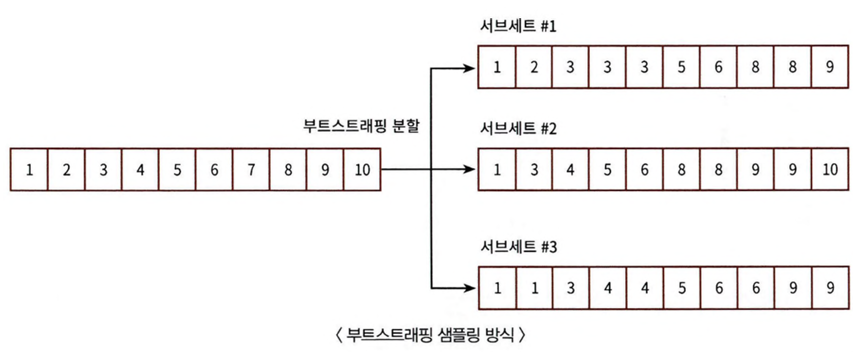

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(
        data=old_feature_name_df.groupby('column_name').cumcount(),
        columns=['dup_cnt']
    )

    feature_dup_df = feature_dup_df.reset_index()

    new_feature_name_df = pd.merge(
        old_feature_name_df.reset_index(), feature_dup_df, how='outer'
    )

    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(
        lambda x: x[0] + '_' + str(x[1]) if x[1] > 0 else x[0],
        axis=1
    )

    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)

    return new_feature_name_df


def get_human_dataset():
    feature_name_df = pd.read_csv(
        '/content/drive/MyDrive/ESAA/week5/features.txt', sep='\s+',
        header=None, names=['column_index', 'column_name']
    )

    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    X_train = pd.read_csv('/content/drive/MyDrive/ESAA/week5/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('/content/drive/MyDrive/ESAA/week5/test/X_test.txt', sep='\s+', names=feature_name)

    y_train = pd.read_csv('/content/drive/MyDrive/ESAA/week5/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('/content/drive/MyDrive/ESAA/week5/test/y_test.txt', sep='\s+', header=None, names=['action'])

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test=get_human_dataset()

rf_clf=RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train,y_train)
pred=rf_clf.predict(X_test)
accuracy=accuracy_score(y_test,pred)
print('랜덤 포레스트 정확도:{0:.4f}'.format(accuracy))

랜덤 포레스트 정확도:0.9220


###랜덤 포레스트 하이퍼 파라미터 및 튜닝

* n_estimators: 결정 트리의 개수 지정/디폴트 10개/증가한다고 항상 성능 향상되는 것 아님
* max_features: 결정트리에 사용된 파리미터와 동일/디폴트가 전체 피처가 아니고 sqrt만큼인 것이 차이
* max_depth, min_samples_leaf, min_samples_split는 결정트리와 동일


GridSearchCV 시도

In [ ]:
from sklearn.model_selection import GridSearchCV
params={
    'max_depth': [8,16,24],
    'min_samples_leaf':[1,6,12],
    'min_samples_split':[2,8,16]
}
rf_clf=RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1)
grid_cv=GridSearchCV(rf_clf, param_grid=params,cv=2,n_jobs=-1)
grid_cv.fit(X_train,y_train)
print('최적 하이퍼 파라미터:',grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터: {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 16}
최고 예측 정확도: 0.9157


In [ ]:
rf_clf1=RandomForestClassifier(n_estimators=100,min_samples_leaf=6,max_depth=16,
                               min_samples_split=2,random_state=0)
rf_clf1.fit(X_train,y_train)
pred=rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test,pred)))

예측 정확도: 0.9253


feature_importance_속성을 이용해 피처의 중요도 알 수 있음

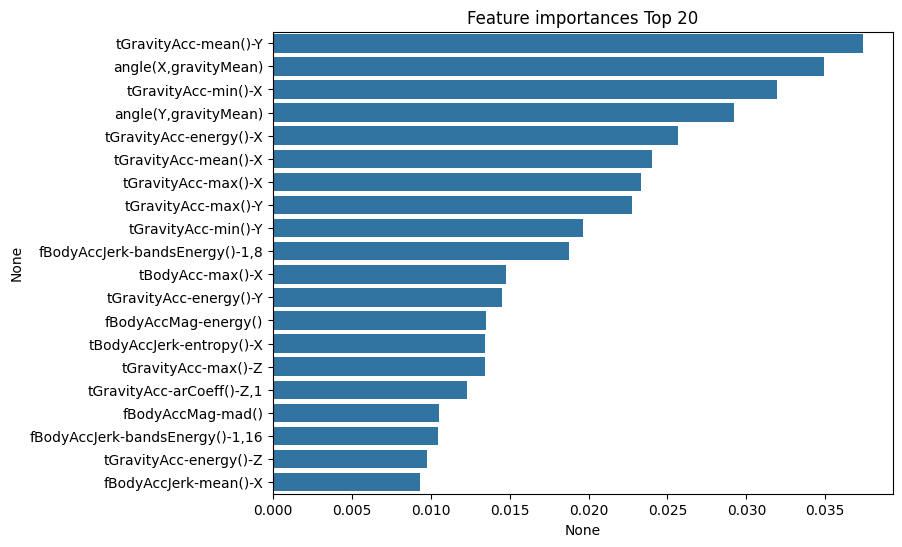

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

ftr_importances_values=rf_clf1.feature_importances_
ftr_importances=pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20,y=ftr_top20.index)
plt.show()

##GBM(Gradient Boosting Machine)

부스팅 알고리즘: 여러개의 약한 학습기를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
1. AdaBoost: 오류 데이터에 가중치를 부여하면서 부스팅을 수행하는 대표적인 알고리즘
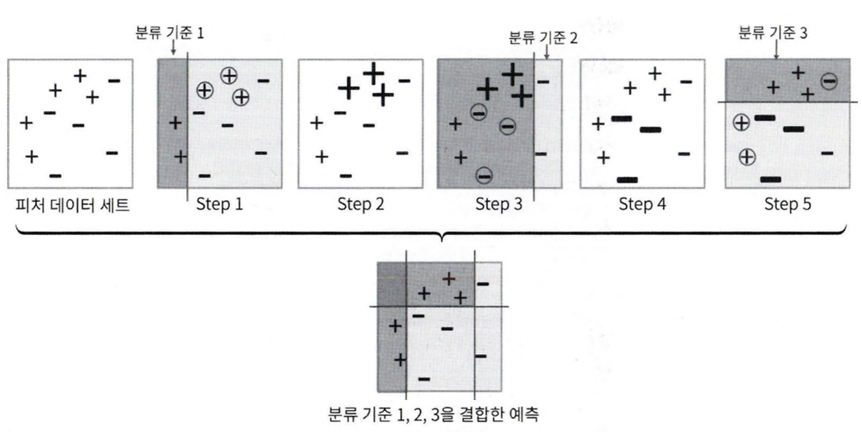

2. GBM(Gradient Boost Machine)

경사 하강법

y: 실제 결괏값/x1,x2...:피처/피처에 기반한 예측함수 F(x)

* 오류식 h(x)=y-F(x)을 최소화 하는 방향성을 가지고 반복적으로 가중치 값을 업데이트 하는 것
* 분류와 회귀 모두 가능
* 얕은 트리를 여러 개 쌓는 게 핵심 아이디어
* GradientBoostingClassifier()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')
X_train,X_test,y_train,y_test= get_human_dataset()

start_time=time.time()
gb_clf=GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train,y_train)
pred=gb_clf.predict(X_test)
accuracy=accuracy_score(y_test,pred)
print('GBM 정확도: {0:.4f}'.format(accuracy))
print("GBM 수행시간: {0:.1f}초".format(time.time()-start_time))

GBM 정확도: 0.9379
GBM 수행시간: 1532.3초


수행 시간이 랜덤포레스트보다 오래 걸리지만 예측 성능은 조금 뛰어난 경우가 많음

극복해야할 과제: 수행 시간/병렬 처리가 지원되지 않아 대용량 데이터에 매우 많은 시간 필요

###GBM 하이퍼 파라미터 소개

n_estimators,max_depth,max_features는 앞과 동일

* loss: 경사 하강법에서 사용할 비용 함수를 지정/디폴트: deviance
* learning_rate:
  * GBM이 학습을 진행할 때마다 적용하는 학습률
  * Weak LEarner가 순차적으로 오류값을 보정해 나가는데 적용하는 계수(0-1사이)
  * 디폴트:0.1
  * 작은 값 적용시 최소 오류 값을 찾아 예측 성능이 높아질 가능성이 높으나 많은 weak learner는 수행 시간이 오래 걸리고 모든 weak learner 반복이 완료되어도 최소 오류 값을 찾지 못할 수 있음
  * 큰 값 적용시 최소 오류 값을 찾지 못하고 지나처 버려 예측 성능 떨어질 수 있음
  * learning_rate를 작게하고 n_estimators를 크게 하면 예측 성능이 좋아지나 수행시간이 오래 걸리고 현격히 좋아지지 않음
* n_estimators: weak learner의 개수/ 개수가 많을 수록 일정 수준까지는 예측성능이 좋아짐/디폴트 100
* subsample: weak learner가 학습에 사용하는 데이터 샘플링 비율/ 기본값 1(데이터 전체)/ 과적합 우려시 1보다 작은 값 설정

##06 XGBoost(eXtra Gradient Boost)

### XGBoost 개요

* 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나
* GBM기반하나 느린 수행 시간 및 과적합 규재 부재 등의 문제 해결하여 각광
* 병렬학습 가능
* Tree pruning 나무 가지치기: 더 이상 긍정
* 이득이 없는 분할을 가지치기 해서 분할 수를 줄임
* 자체 내장 교차 검증: 반복 수행마다 교차 검증을 수행해 최적화된 반복 수행 횟수 가짐/지정된 반복 횟수가 아니라 교차 검증을 통해 평가 값이 최적화 되면 반복 조기 중단


In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

###파이썬 래퍼 XGBoost 하이퍼 파라미터

파이썬 래퍼 GBM 모듈과 사이킷런 래퍼 XGBoost 모듈의 일부 하이퍼 파라미터는 약간 다름

* XGBoost 하이퍼 파라미터 유형
  * 일반 파라미터: 일반적으로 실행 시 스레드의 개수나 silent모드 등의 선책을 위한 파라미터로서 디폴트 파라미터 값을 바꾸는 일은 거의 없음
  * 부스터 파라미터: 트리 최적화, 부스팅, regularization등과 관련 파라미터 등을 지칭
  * 학습 태스크 파라미터: 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정

* 주요 일반 파라미터
  * booster: gbtree(디폴트) 또는 gblinear 선택
  * silent: 디폴트 0/출력 메시지를 나타내고 싶지 않을 경우 1
  * nthread: CPU 실행 스레드 개수를 조정/디폴트는 전체 스레드 사용

* 주요 부스터 파라미터
  * eta[default=0.3, alias:learning_rate]:GBM의 학습률과 같은 파라미터/사이킷런 래퍼 클래스에서 learning_rate로 대체(디폴트 0.1)
  * num_boost_rounds: GBM의 n_estimators와 같은 파라미터
  * min_child_weight: 디폴트 1/ 트리에서 추가적으로 가지를 나눌지 결정하기 위해 필요한 데이터들의 weight 총합/클수록 분할 자제해 과적합 조절
  * gamma: 디폴트 0/alias min_split_loss/트리의 리프 노드를 추가적으로 나눌지 결정할 최소 손실 감소 값/해당 값보다 큰 손실이 감소된 경우에 리프 노드 분리/값이 클수록 과적합 감소
  * max_depth: 디폴트 6/트리 기반 알고리즘과 같음/ 0 지정시 깊이에 제한 없음/보통 3-10사이
  * sub_sample: 디폴트 1: GBM과 동일/트리가 커져서 과적합 되는 것을 제어하기 위해 데이터를 샘플링하는 비율 지정/보통0.5-1
  * colsample_bytree: 디폴트 1/ GBM의 max_features와 유사/트리 생성에 필요한 피처를 임의로 샘플링 하는데 사용/ 매우 많은 피처가 있는 경우 과적합 조정
  * lambda: 디폴트 1/alias:reg_lambda/L2 Regularization 적용 값/클수록 과적합 감소 효과
  * alpha: 디폴트=0/alias:reg_alpha/L1 Regularization 적용값/피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과
  * scale_pos_weight:디폴트 1/ 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터

* 학습 태스크 파라미터
  * objective: 최솟값을 가져야 할 손실 함수를 정의/이진분류인지 다중분류인지에 따라 달라짐
  * binary:logistic: 이진 분류일때 사용
  * multi:softmax : 다중 분류일 때 적용/레이블 클래스의 개수인 num_class 파라미터를 지정해야함
  * multi:softprob: multi:softmax와 비슷하나 개별 레이블 클래스에 해당되는 예측 확률 반환
  * eval_metric: 검증에 사용되는 함수를 정의/기본값은 회귀인 경우는 rmse, 분류일 경우에는 error
  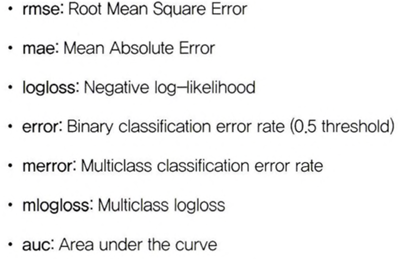
  
-과적합 문제가 있는 경우
> eta 값 낮추고(0.01~0.1) num_round(또는 n_estimators)는 반대로 높이기  
max_depth값 낮추기  
min_child_weight 값 높이기  
gamma값 높이기  
subsample, colsample_bytree 조정  



조기중단 파라미터: n_estimators값까지 반복하지 않더라도 조기중단 파리미터값을 반복하는 동안 학습 오류가 감소하지 않으면 더이상 부스팅 진행하지 않고 종료


In [ ]:
import xgboost
print(xgboost.__version__)

3.0.5


### 파이썬 래퍼 XGBoost 적용- 위스콘신 유방암 예측

자체적으로 교차검증, 성능 평가,조기 중단, 피처 중요도 등의 시각화 기능 가짐

In [1]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
dataset=load_breast_cancer()
features=dataset.data
labels=dataset.target

In [2]:
cancer_df=pd.DataFrame(data=features,columns=dataset.feature_names)
cancer_df['target']=labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [3]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


80%를 학습용으로 추출하고 여기서 10%를 검증용으로 다시 분할

In [6]:
X_features=cancer_df.iloc[:,:-1]
y_label=cancer_df.iloc[:,-1]

X_train,X_test,y_train,y_test=train_test_split(X_features, y_label,test_size=0.2,random_state=156)
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=156)
print(X_train.shape,X_test.shape)
print(X_tr.shape,X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


파이썬 레퍼는 XGBoost만의 전용 데이터 객체 DMatrix를 사용해야함
넘파이,DF,Series 등을 변환가능

In [8]:
dtr=xgb.DMatrix(data=X_tr,label=y_tr)
dval=xgb.DMatrix(data=X_val,label=y_val)
dtest=xgb.DMatrix(data=X_test,label=y_test)

#하이퍼 파라미터는 주로 딕셔너리 형태
params={'max_depth':3,
        'eta':0.05,
        'objective':'binary:logistic',
        'eval_metric':'logloss'
}
num_rounds=400

조기 중단을 수행하기 위해 반드시 평가용 데이터 세트 지정과 eval_metric을 함께 지정해야함

학습용과 평가용을 튜플로 명기한 리스트 형태로 설정
eval_metric은 error, logloss 주로 적용

In [9]:
eval_list=[(dval,'eval')]

xgb_model=xgb.train(params=params,dtrain=dtr,num_boost_round=num_rounds,early_stopping_rounds=50,evals=eval_list)

[0]	eval-logloss:0.63088
[1]	eval-logloss:0.60461
[2]	eval-logloss:0.58205
[3]	eval-logloss:0.56165
[4]	eval-logloss:0.54101
[5]	eval-logloss:0.52206
[6]	eval-logloss:0.50271
[7]	eval-logloss:0.48606
[8]	eval-logloss:0.46961
[9]	eval-logloss:0.45485
[10]	eval-logloss:0.44120
[11]	eval-logloss:0.43123
[12]	eval-logloss:0.41962
[13]	eval-logloss:0.40848
[14]	eval-logloss:0.39857
[15]	eval-logloss:0.38945
[16]	eval-logloss:0.38171
[17]	eval-logloss:0.37381
[18]	eval-logloss:0.36656
[19]	eval-logloss:0.36014
[20]	eval-logloss:0.35395
[21]	eval-logloss:0.34726
[22]	eval-logloss:0.34194
[23]	eval-logloss:0.33611
[24]	eval-logloss:0.33170
[25]	eval-logloss:0.32730
[26]	eval-logloss:0.32357
[27]	eval-logloss:0.31915
[28]	eval-logloss:0.31569
[29]	eval-logloss:0.31236
[30]	eval-logloss:0.30978
[31]	eval-logloss:0.30645
[32]	eval-logloss:0.30403
[33]	eval-logloss:0.30108
[34]	eval-logloss:0.29780
[35]	eval-logloss:0.29599
[36]	eval-logloss:0.29444
[37]	eval-logloss:0.29141
[38]	eval-logloss:0.28

In [10]:
pred_probs=xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측확률로 표시됨')
print(np.round(pred_probs[:10],3))

preds=[1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ',preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측확률로 표시됨
[0.938 0.004 0.776 0.058 0.975 1.    0.999 0.999 0.998 0.   ]
예측값 10개만 표시:  [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,f1_score, roc_auc_score

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)

    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))


In [22]:
get_clf_eval(y_test,preds,pred_probs)

오차행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740, F1: 0.9740, AUC: 0.9600


내장된 plot_importance() 이용해 피처 중요도 시각화 가능
맷플롯립 ax객체 입력해주기

넘파이 기반의 피처 데이터 학습 시 피처명 알 수 없음

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

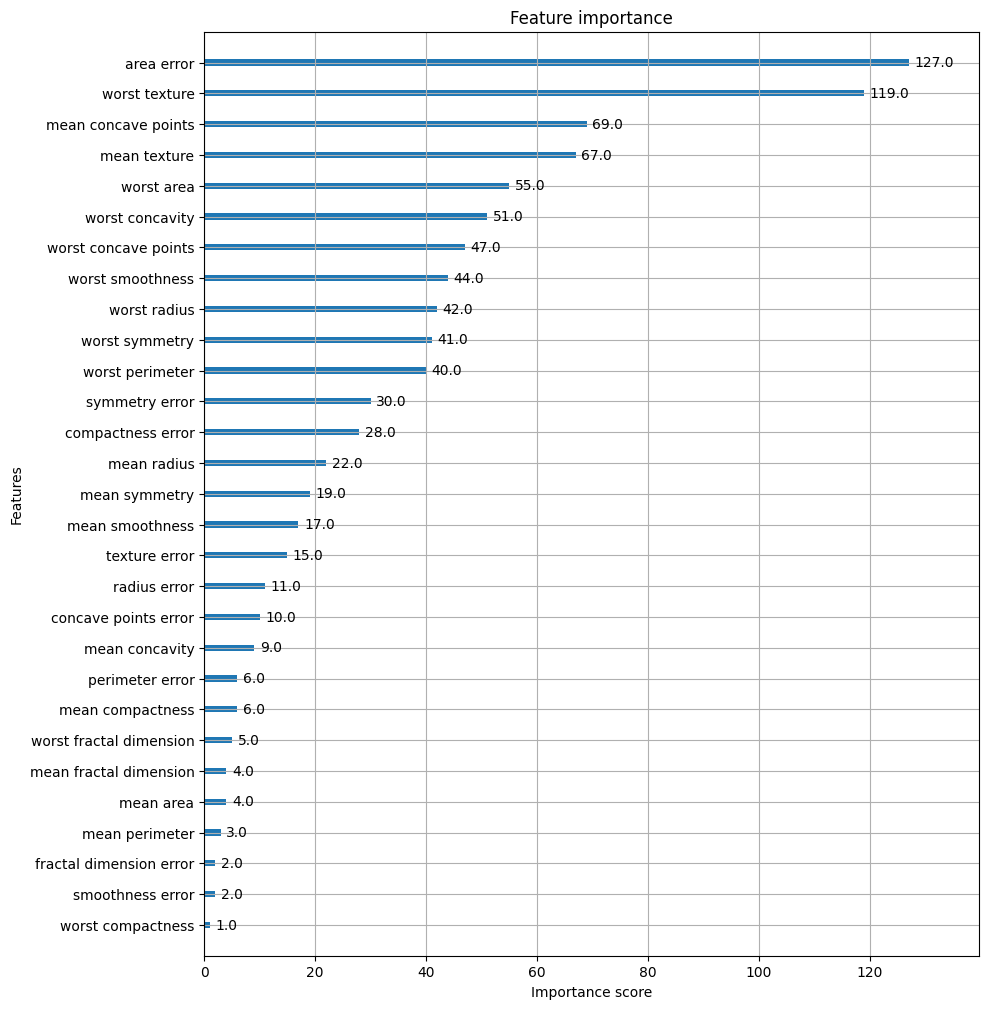

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)


to_graphiviz를 이용해 규칙 트리 구조를 그릴 수 있음

GridSearchCV와 유사한 교차 검증 수행 후 최적 파라미터를 구할 수 있는 방법을 cv()로 제공

* params: 부스터 파라미터
* dtrain: 학습 데이터
* num_boost_round (int)： 부스팅 반복 횟수
* nfold (int)： CV 폴드 개수
* stratified (bool): CV 수행 시 층화 표본 추출(stratified sampling) 수행 여부
* metrics (string or list of strings)：CV 수행 시 모니터링할성능 평가지표
* early_stopping_rounds (int) ： 조기 중단을 활성화시킴. 반복 횟수 지정

### 사이킷런 래퍼 XGBoost의 개요 및 적용

사이킷런 기본 Estimator 사용 가능
XGBClassifier / XGBRegressor

-변경 파라미터
* eta->learning_rate
* sub_sample->subsample
* lambda->reg_lambda
* alpha-> reg_alpha

* n_estimator=num_boost_round

In [25]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.05,max_depth=3,eval_metric='logloss')
xgb_wrapper.fit(X_train,y_train,verbose=True)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

In [26]:
get_clf_eval(y_test,w_preds,w_pred_proba)

오차행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9530


더 좋은 평가결과 나옴

이유: 학습데이터를 다시 평가 데이터로 분리하면서 학습 데이터 건수가 작아져서 발생


조기중단 파라미터 fit()에 early_stopping_rounds입력, 평가수행할 데이터 세트 eval_set, 조기중단 평가 지표 eval_metric

In [34]:
wgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.05,max_depth=3,early_stopping_rounds=50,eval_metric='logloss')
evals=[(X_tr,y_tr),(X_val,y_val)]
xgb_wrapper.fit(X_tr,y_tr,eval_set=evals,verbose=True)
ws50_preds=xgb_wrapper.predict(X_test)
ws50_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.62473	validation_1-logloss:0.63088
[1]	validation_0-logloss:0.58662	validation_1-logloss:0.60461
[2]	validation_0-logloss:0.55210	validation_1-logloss:0.58205
[3]	validation_0-logloss:0.52068	validation_1-logloss:0.56165
[4]	validation_0-logloss:0.49173	validation_1-logloss:0.54101
[5]	validation_0-logloss:0.46517	validation_1-logloss:0.52206
[6]	validation_0-logloss:0.44009	validation_1-logloss:0.50271
[7]	validation_0-logloss:0.41646	validation_1-logloss:0.48606
[8]	validation_0-logloss:0.39505	validation_1-logloss:0.46961
[9]	validation_0-logloss:0.37523	validation_1-logloss:0.45485
[10]	validation_0-logloss:0.35682	validation_1-logloss:0.44120
[11]	validation_0-logloss:0.33964	validation_1-logloss:0.43123
[12]	validation_0-logloss:0.32279	validation_1-logloss:0.41962
[13]	validation_0-logloss:0.30783	validation_1-logloss:0.40848
[14]	validation_0-logloss:0.29308	validation_1-logloss:0.39857
[15]	validation_0-logloss:0.27928	validation_1-logloss:0.38945
[1

In [30]:
get_clf_eval(y_test,ws50_preds,ws50_pred_proba)

오차행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740, F1: 0.9740, AUC: 0.9600


조기중단값을 줄이면 예측 성능 저하 우려

In [32]:
wgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.05,max_depth=3,
                          early_stopping_rounds=10,eval_metric='logloss')
evals=[(X_tr,y_tr),(X_val,y_val)]
xgb_wrapper.fit(X_tr,y_tr,eval_set=evals,verbose=True)
ws50_preds=xgb_wrapper.predict(X_test)
ws50_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test,ws50_preds,ws50_pred_proba)

[0]	validation_0-logloss:0.62473	validation_1-logloss:0.63088
[1]	validation_0-logloss:0.58662	validation_1-logloss:0.60461
[2]	validation_0-logloss:0.55210	validation_1-logloss:0.58205
[3]	validation_0-logloss:0.52068	validation_1-logloss:0.56165
[4]	validation_0-logloss:0.49173	validation_1-logloss:0.54101
[5]	validation_0-logloss:0.46517	validation_1-logloss:0.52206
[6]	validation_0-logloss:0.44009	validation_1-logloss:0.50271
[7]	validation_0-logloss:0.41646	validation_1-logloss:0.48606
[8]	validation_0-logloss:0.39505	validation_1-logloss:0.46961
[9]	validation_0-logloss:0.37523	validation_1-logloss:0.45485
[10]	validation_0-logloss:0.35682	validation_1-logloss:0.44120
[11]	validation_0-logloss:0.33964	validation_1-logloss:0.43123
[12]	validation_0-logloss:0.32279	validation_1-logloss:0.41962
[13]	validation_0-logloss:0.30783	validation_1-logloss:0.40848
[14]	validation_0-logloss:0.29308	validation_1-logloss:0.39857
[15]	validation_0-logloss:0.27928	validation_1-logloss:0.38945
[1

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

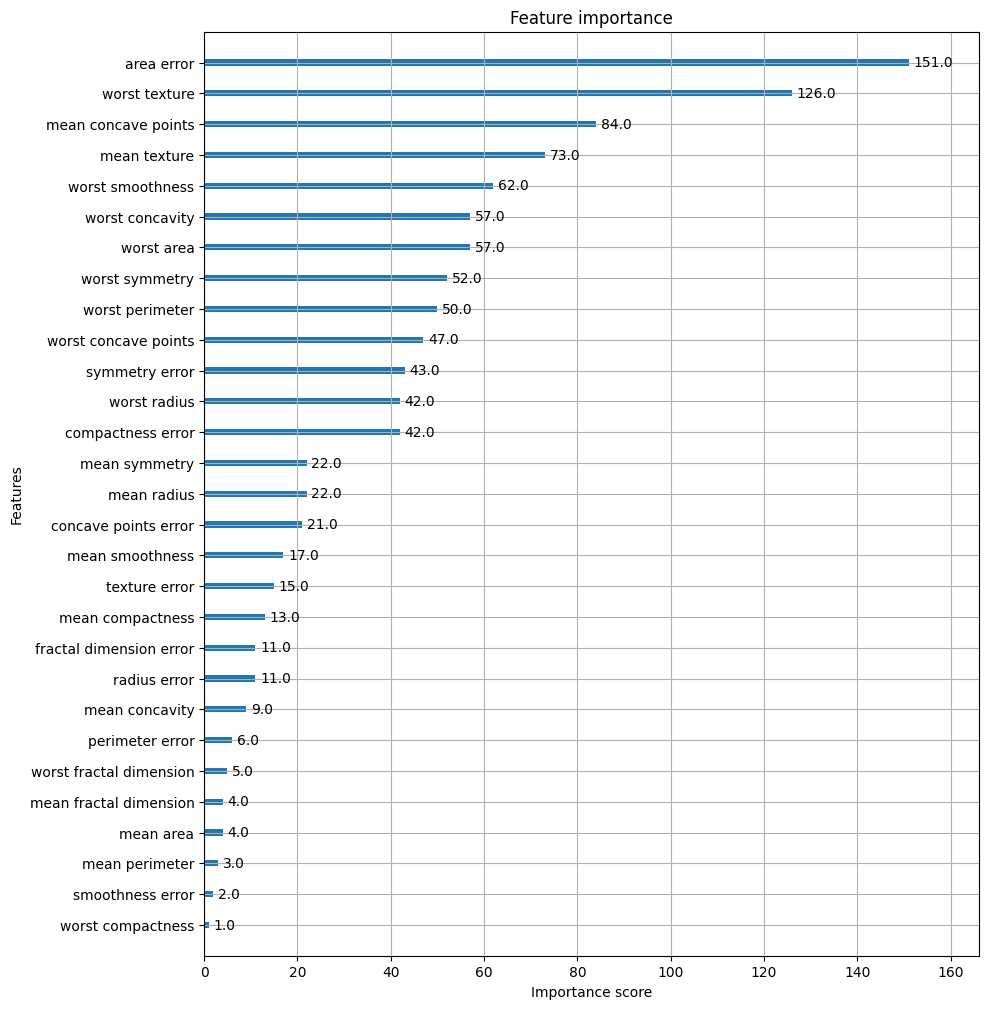

In [37]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper,ax=ax)